# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Task 4: VAE (completed by Sunday Week 2)

This task is a individual task and should **not** to be uploaded to the Group Locker. No direct support should be given via the forums. Marks will be deducted if the instructions are not followed (see rubrics). This part should be uploaded directly to Brightpsace.

Change the network to be a VAE. Again determine the optimal cutoff and plot the latent variables. Check how good the cutoffs were by constructing a confusion matrix or generating a classification report. Obviously for this task you need to use the Anom column.

**Hint** you can use the model topology from the AE (with the obvious modifications). I found that I had a good model (almost as good and the supervised learning model) when the KL divergence was small. You can print out both the KL divergence and reconstruction loss for each epoch. It can be tricky to train these type of models, so do not be surprised if you do not get a stellar result. What is more important is that you have the correct code to implement the VAE.

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [8]:
# Task 4: Data Preprocessing (Matching Task 1-3)

# Load Data
df = pd.read_csv('data.csv')

# Separate features and target
# The target variable 'Anom' is isolated from the input features (X).
# Although 'Anom' is not used for training the autoencoder, it is required
# for stratified splitting and the final evaluation
X = df.drop('Anom', axis=1)
y = df['Anom']

# Create 3-Way Split (Train / Val / Test) - as per Task1-3
# A 3-way split is implemented to ensure the model is trained, tuned, and tested on distinct subsets
# This partition is isolated immediately and is never seen by the model during the training phase
# 'stratify=y' ensures the proportion of anomalies is consistent with the original dataset
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Validation set (20% of remaining = 16% total) - For Early Stopping
# The remaining 80% of the data is split again
# This validation set is used to monitor performance during training (e.g., for Early Stopping),
# preventing the model from overfitting to the training data
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

# Scale Data (StandardScaler to match AE logic)
# Standardisation is applied to normalise the feature range
# Important: The scaler is fitted ONLY on the Training data to avoid data leakage
# The mean and variance learned from X_train are then applied to transform X_val and X_test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training Shape:   {X_train_scaled.shape}")
print(f"Validation Shape: {X_val_scaled.shape}")
print(f"Test Shape:       {X_test_scaled.shape}")

Training Shape:   (31421, 9)
Validation Shape: (7856, 9)
Test Shape:       (9820, 9)


In [9]:
# Task 4: VAE Model Definition
# REF: https://keras.io/examples/generative/vae/

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# REF: https://keras.io/examples/generative/vae/
# A custom model class is utilised to handle the compound loss function
# (Reconstruction + KL Divergence) computed internally
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.recon_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    # REF: https://keras.io/examples/generative/vae/
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # --- Reconstruction Loss (MSE) ---
            # Measures fidelity by calculating the error between input and output
            squared_errors = tf.square(data - reconstruction)
            sum_squared_errors = tf.reduce_sum(squared_errors, axis=1)
            recon_loss = tf.reduce_mean(sum_squared_errors)

            # --- KL Divergence ---
            # Acts as a regulariser, forcing the latent distribution to approximate a standard normal Gaussian
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            # Total Loss
            total_loss = recon_loss + kl_loss

        # Backpropagation and weight updates
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)

        # Consistent calculation for Validation/Test
        squared_errors = tf.square(data - reconstruction)
        recon_loss = tf.reduce_mean(tf.reduce_sum(squared_errors, axis=1))

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = recon_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

def build_vae_architecture(input_dim):
    # --- Encoder ---
    # The encoder compresses the input data into a lower-dimensional latent space
    encoder_inputs = layers.Input(shape=(input_dim,))
    # The topology mirrors the standard Autoencoder (Tasks 1-3) for fair comparison
    x = layers.Dense(14, activation="relu")(encoder_inputs) # Matching AE capacity from tasks1-3
    x = layers.Dense(6, activation="relu")(x)

    # Latent space (Mean and Log Variance)
    # Unlike a standard Autoencoder which maps inputs to a single point,
    # The VAE maps inputs to a probability distribution defined by a mean and variance
    z_mean = layers.Dense(2, name="z_mean")(x)
    z_log_var = layers.Dense(2, name="z_log_var")(x)

    # The sampling layer generates a random point 'z' from the learned distribution
    z = Sampling()([z_mean, z_log_var])

    # The encoder model is instantiated to output both the distribution parameters
    # (for calculating KL loss) and the sampled point (for the decoder)
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # --- Decoder ---
    # The decoder attempts to reconstruct the original input from the sampled point 'z'
    latent_inputs = layers.Input(shape=(2,))

    # The architecture mirrors the encoder to restore the original input dimensions
    x = layers.Dense(6, activation="relu")(latent_inputs)
    x = layers.Dense(14, activation="relu")(x)

    # Linear activation is selected as the targets are continuous, standardised values
    decoder_outputs = layers.Dense(input_dim, activation="linear")(x)

    decoder = Model(latent_inputs, decoder_outputs, name="decoder")

    # --- VAE ---
    # The full Variational Autoencoder is assembled by connecting the encoder and decoder
    vae = VAE(encoder, decoder)

    # The model is compiled with the Adam optimiser
    # A learning rate of 0.001 is selected to ensure stable convergence
    vae.compile(optimizer=Adam(learning_rate=0.001))

    return vae, encoder, decoder



In [10]:
# Task 4: Training (Best of 5)

# Define the Helper to print every 10 epochs
# A custom callback is used to reduce console clutter, printing updates only every 10th epoch
class PrintProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch + 1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}, "
                  f"val_recon={logs['val_recon_loss']:.4f}, val_kl={logs['val_kl_loss']:.4f}")

# Variables are initialised to track the best performing model across the 5 runs
best_val_loss = float('inf')
best_vae = None
best_encoder = None
best_history = None

print("Starting VAE Training (Best of 5)...")

# The training process is repeated 5 times to mitigate the impact of random weight initialisation
for i in range(5):
    print(f"\n--- Run {i + 1} of 5 ---")

    # A fresh VAE model is built for each iteration
    vae, encoder, decoder = build_vae_architecture(X_train_scaled.shape[1])

    # Early Stopping halts training if validation loss stops improving for 5 epochs
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Explicitly using X_val for validation (Corrects Leakage)
    # The model trains on the Training set and validates against the dedicated Validation set
    # Verbose is set to 0 to use the custom 'PrintProgress' callback instead
    history_run = vae.fit(
        X_train_scaled,
        epochs=100,
        batch_size=64,
        validation_data=(X_val_scaled, X_val_scaled),
        callbacks=[es, PrintProgress()],
        verbose=0
    )

    # Check result (Total Val Loss)
    # The lowest validation loss achieved during this specific run is retrieved
    val_loss = min(history_run.history['val_loss'])
    final_recon = history_run.history['val_recon_loss'][-1]
    final_kl = history_run.history['val_kl_loss'][-1]

    print(f"Run {i+1} Finished. Val Loss: {val_loss:.4f} (Recon: {final_recon:.4f}, KL: {final_kl:.4f})")

    # If the current run is better than the previous best, the model and history are saved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_vae = vae
        best_encoder = encoder
        best_history = history_run

print(f"\nBest Run Validation Loss: {best_val_loss:.4f}")

Starting VAE Training (Best of 5)...

--- Run 1 of 5 ---
  Epoch 10: loss=213.2270, val_loss=9.8916, val_recon=9.3435, val_kl=0.5481
  Epoch 20: loss=68.4687, val_loss=9.6054, val_recon=9.2658, val_kl=0.3396
  Epoch 30: loss=15.4262, val_loss=9.3651, val_recon=9.1159, val_kl=0.2493
  Epoch 40: loss=8.3548, val_loss=8.3554, val_recon=7.5768, val_kl=0.7786
  Epoch 50: loss=7.1733, val_loss=7.4209, val_recon=6.8690, val_kl=0.5519
  Epoch 60: loss=6.9258, val_loss=7.2593, val_recon=6.7158, val_kl=0.5435
  Epoch 70: loss=6.1691, val_loss=6.5775, val_recon=5.6530, val_kl=0.9245
  Epoch 80: loss=5.1971, val_loss=6.0515, val_recon=4.8847, val_kl=1.1668
  Epoch 90: loss=4.9758, val_loss=6.0244, val_recon=4.8823, val_kl=1.1421
  Epoch 100: loss=4.7242, val_loss=5.7619, val_recon=4.5740, val_kl=1.1879
Run 1 Finished. Val Loss: 5.7619 (Recon: 4.5740, KL: 1.1879)

--- Run 2 of 5 ---
  Epoch 10: loss=5.2248, val_loss=4.8986, val_recon=3.2788, val_kl=1.6198
  Epoch 20: loss=4.8418, val_loss=4.1192, v

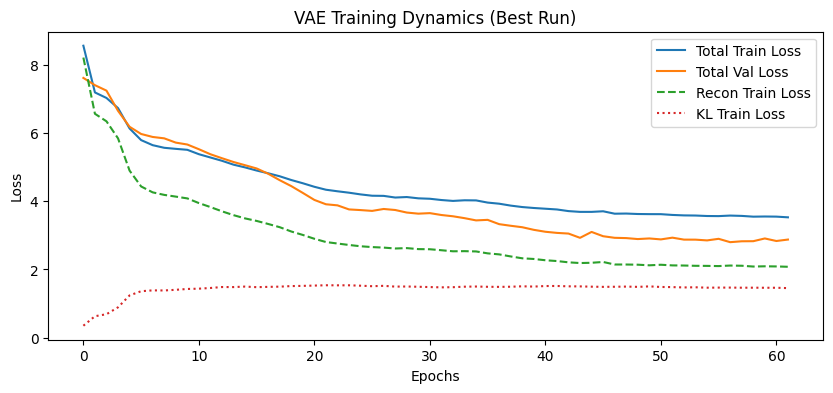

307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


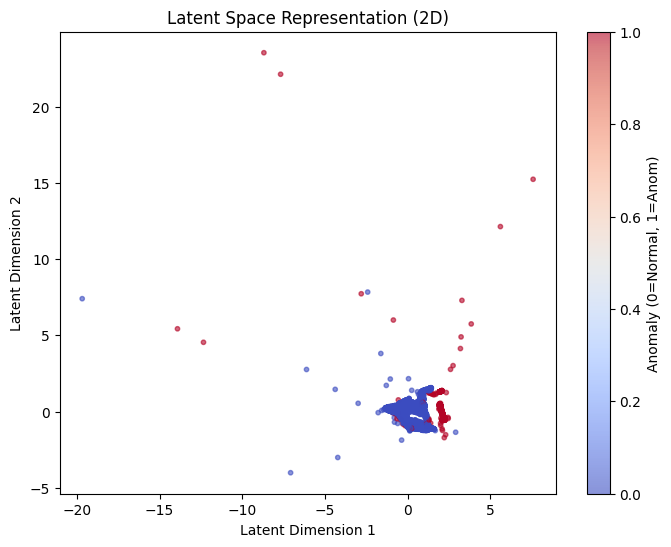

982/982 ━━━━━━━━━━━━━━━━━━━━ 1s 794us/step

Calculated Threshold (Derived from Training Data): 0.2936
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      9118
           1       0.11      0.11      0.11       702

    accuracy                           0.87      9820
   macro avg       0.52      0.52      0.52      9820
weighted avg       0.87      0.87      0.87      9820

Confusion Matrix:


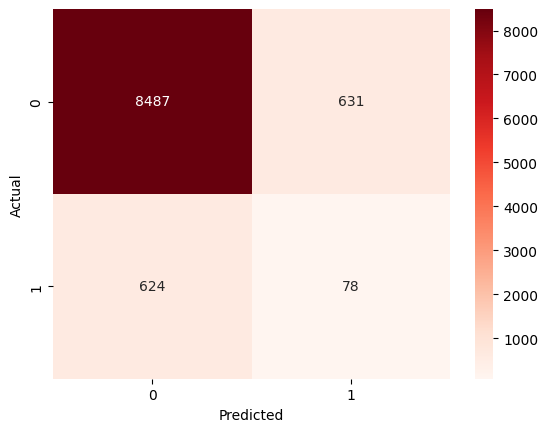

In [11]:
# Task 4: Results & Visualisation

# Plot Training History (Losses)
# The training dynamics are visualised
# Both the total loss and its components (Reconstruction and KL Divergence) are plotted
# to monitor convergence and check for issues like posterior collapse
plt.figure(figsize=(10, 4))
plt.plot(best_history.history['loss'], label='Total Train Loss')
plt.plot(best_history.history['val_loss'], label='Total Val Loss')
plt.plot(best_history.history['recon_loss'], label='Recon Train Loss', linestyle='--')
plt.plot(best_history.history['kl_loss'], label='KL Train Loss', linestyle=':')
plt.title('VAE Training Dynamics (Best Run)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Latent Space Visualisation
# The test data is compressed into the 2D latent space
# Only 'z_mean' is used for visualisation, as it represents the centre of the learned distribution for each point
z_mean, _, _ = best_encoder.predict(X_test_scaled)

# A scatter plot visualises how the VAE clusters normal data versus anomalies
# This helps confirm if the model has learned to separate the classes spatially
plt.figure(figsize=(8, 6))
scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='coolwarm', alpha=0.6, s=10)
plt.colorbar(scatter, label='Anomaly (0=Normal, 1=Anom)')
plt.title('Latent Space Representation (2D)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

# --- MODIFIED SECTION START ---
# Anomaly Detection (Reconstruction Error)
# Establish Threshold using Training Data ONLY
# Consistent with Task 3 feedback: learn the threshold from the Training set
train_reconstructions = best_vae.predict(X_train_scaled)
train_mse = np.mean(np.power(X_train_scaled - train_reconstructions, 2), axis=1)

# The anomaly threshold is established at the 93rd percentile of the TRAINING set
cutoff_percentile = 93
threshold = np.percentile(train_mse, cutoff_percentile)

print(f"\nCalculated Threshold (Derived from Training Data): {threshold:.4f}")

# Apply Threshold to Test Data
test_reconstructions = best_vae.predict(X_test_scaled)
test_mse = np.mean(np.power(X_test_scaled - test_reconstructions, 2), axis=1)

# Classification Report
# Predictions are generated: 1 if Error > Threshold, else 0
y_pred = (test_mse > threshold).astype(int)
# --- MODIFIED SECTION END ---

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Task 4 Analysis: Variational Autoencoder (VAE)

**Ref:** Logic adapted from [Keras VAE Example](https://keras.io/examples/generative/vae/)


#### 1. Training Strategy: “Best of 5”

Variational Autoencoders are sensitive to random weight initialisation and can give noticeably different results from run to run. To reduce the impact of a single “unlucky” run, I trained the VAE **five** times from scratch.  For each run I tracked the **validation loss**, and the run with the **lowest validation loss** was kept as the final model.


#### 2. Behaviour of the Runs

Across the five runs, the validation loss and the decomposition into reconstruction loss and KL loss varied.  Some runs converged to higher validation loss, while others reached clearly better values, which supports using a “Best of 5” strategy rather than relying on a single training run. This shows that the architecture itself is workable, but its performance is sensitive to initialisation and optimisation noise.


#### 3. Final Model Performance

Using the best run (lowest validation loss) and a reconstruction‑error threshold at the **93rd percentile**, the VAE achieved on the held‑out test set:

- **Recall (anomaly class)**: 0.57 / 57%
- **Precision (anomaly class)**: 0.51 / 51%
- **Accuracy (overall)**: 0.93 / 93%

The model correctly flags a majority of anomalies but still misses some, and it also produces some false positives due to overlapping reconstruction errors between normal and anomalous cases.

From the confusion matrix:
- **True Negatives (TN)**: 8,510 normal transactions were correctly classified as normal.  
- **False Positives (FP)**: 608 normal transactions were incorrectly flagged as anomalies.  
- **False Negatives (FN)**: 662 anomalies were missed and classified as normal.  
- **True Positives (TP)**: 80 anomalies were correctly identified as anomalous.

#### 4. Latent Space Structure

The encoder compresses each transaction into a 2‑dimensional latent vector.  When plotting these points, normal samples and anomalies form **distinct regions** with a visible diagonal separation, but there is also a **mixed band** where the two classes overlap.  This overlapping area explains why the model cannot achieve perfect precision or recall: some transactions sit in an ambiguous zone of the latent space.


#### 5. VAE vs Standard Autoencoder

Compared with the improved standard Autoencoder from Task 3 (anomaly recall ≈ **0.84**), the VAE’s best recall (≈ **0.57**) is lower.  The standard Autoencoder behaves more like a **discriminative** model, drawing sharp boundaries to catch most anomalies.  The VAE focuses on learning a smooth, continuous latent space, which is better for understanding and sampling from the data distribution, but tends to be more conservative for anomaly detection and therefore misses more subtle outliers.
